In [ ]:
import pandas as pd
import numpy as np
import glob as glob
import os

import multiprocessing
import re
from rdkit.Chem import rdchem

from subprocess import check_output

import hashlib
import pandas as pd

# sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network')
import build_tools as wt


# sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

# sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/blink')

import blink


# Set the display width for pandas columns
pd.set_option('display.max_colwidth', None)
# show more pandas columns
pd.set_option('display.max_columns', 500)


In [116]:
def get_files_from_disk(directory,extension):
    """
    Get on disk with date
    """
    get_with_date = ''.join(['find %s -iname "*%s"' % (directory,extension),' -printf "%Ts SplitThat%p\n"'])
    files = check_output(get_with_date, shell=True)
    files = files.decode('utf-8').splitlines()
    files = [f.split('SplitThat') for f in files]
    dates = [int(f[0].strip()) for f in files]
    files = [f[1].strip() for f in files]
    return dates,files

half_precursor_tolerance = 0.001 # since we typically use 0.002 as the precursor tolerance, we can use 0.001 as the half tolerance

data_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
metadata_folder = '/global/cfs/cdirs/metatlas/projects/carbon_network'
environmental_metatlas_folder = os.path.join(data_dir,'metatlas')
metatlas_no_buddy_folder = os.path.join(data_dir,'metatlas_no_buddy')


# Get metatlas-no-buddy  files
dates, parquet_files = get_files_from_disk(metatlas_no_buddy_folder, 'parquet')
dates, h5_files = get_files_from_disk(metatlas_no_buddy_folder, 'h5')

df = {}
for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f

# Get metatlas environmental files
dates, parquet_files = get_files_from_disk(environmental_metatlas_folder, 'parquet')
dates, h5_files = get_files_from_disk(environmental_metatlas_folder, 'h5')

for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f

# get massive files
dates, parquet_files = get_files_from_disk(os.path.join(data_dir,'massive'), 'parquet')
dates, h5_files = get_files_from_disk(os.path.join(data_dir,'massive'), 'h5')
for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f


for k,v in df.items():
    if environmental_metatlas_folder in k:
        df[k]['experiment_id'] = '_'.join(os.path.basename(k).split('_')[4:6])

for k,v in df.items():
    if metatlas_no_buddy_folder in k:
        df[k]['experiment_id'] = '_'.join(os.path.basename(k).split('_')[4:6])    

df = pd.DataFrame(df).T

# extract the massive ID from the path
pattern = r'(?<=/)(MSV.*?)(?=/)'
a = df.copy().index.str.extract(pattern)
df['massive_id'] = a[0].tolist()

# extract everything from the massive ID to the filename
pattern = r'(\/MSV.*)' 
df['redu_filename'] = df.copy().index.str.extract(pattern,expand=False)
df['redu_filename'] = df['redu_filename'].str.replace(r'^/', 'f.', regex=True)

# ADD IN EXPERIMENT_ID TO DEAL WITH BOTH MASSIVE AND LBL DATASETS
idx = pd.notna(df['massive_id'])
df.loc[idx,'experiment_id'] = df.loc[idx,'massive_id']

df.reset_index(inplace=True,drop=True)

df_grouped = df.groupby('experiment_id').size().reset_index(name='files_per_experiment')
df = pd.merge(df, df_grouped, on='experiment_id', how='left')




# merge massive metadata with all files

In [117]:
usecols = ['title','dataset','description','keywords','instrument']
massive_metadata = pd.read_csv(os.path.join(metadata_folder,'massive_metadata_2024.tsv'), sep='\t',usecols=usecols)
massive_metadata.columns = [c.lower() for c in massive_metadata.columns]
df = pd.merge(df,massive_metadata.add_suffix('_massive'),left_on='massive_id',right_on='dataset_massive',how='left')


# Merge REDU Information

In [118]:
redu = pd.read_csv(os.path.join(metadata_folder,'all_sampleinformation.tsv'), sep='\t')
redu['filename'] = redu['filename'].str.replace(r'\.mz(ML|XML)$', '', regex=True)
redu.columns = [c.lower() for c in redu.columns]
df = pd.merge(df,redu.add_suffix('_redu'),left_on='redu_filename',right_on='filename_redu',how='left')


# MERGE in Environmental Experiment List

In [119]:
environmental_metatlas_folder

'/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas'

In [120]:
dom_samples = pd.read_csv(os.path.join(metadata_folder,'dom_public_datasets.csv'),usecols=['dataset'])
dom_samples = pd.Series(dom_samples['dataset'].unique())
df['environmental'] = (df['massive_id'].isin(dom_samples)) | (df['parquet'].str.contains(environmental_metatlas_folder+'/'))
df.shape

(226979, 49)

# Identify Plant files for manuscript

In [121]:
idx1 = df['sampletype_redu'].str.contains('plant',case=False,na=False)
idx2 = df['parquet'].str.contains('20240409_EB_NB_107915-001_PRISM-RtExu_combined-rep1-5_EXP120A_C18-EP_USDAY72349')
df['plant'] = (idx1) | (idx2)


In [122]:
df = df[pd.notna(df['parquet'])]
df = df[~df['parquet'].str.contains('qc',case=False)]
df = df[~df['parquet'].str.contains('blank',case=False)]
df = df[~df['parquet'].str.contains('exctrl',case=False)]
df[df['plant']].to_csv(os.path.join(metadata_folder,'plant_samples.csv'),index=False)
df[df['plant']].to_csv('plant_samples.csv',index=False)

# Filter to either plant or environment

In [123]:
df = df[df['environmental']]
df.shape

(4676, 50)

# remove rows that do not have a parquet file

In [125]:
df = df[pd.notna(df['parquet'])]
df = df[~df['parquet'].str.contains('qc',case=False)]
df = df[~df['parquet'].str.contains('blank',case=False)]
df.shape


(4676, 50)

# remove duplicate files

In [128]:


def hash_dataframe_row(filename):
    cols = ['precursor_mz', 'rt', 'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr']
    try:
        t = pd.read_parquet(filename)
        hash_value = int(hashlib.sha256(pd.util.hash_pandas_object(t[cols], index=True).values).hexdigest(), 16)
        return hash_value
    except:
        print('Error',filename)
        return None

def parallel_hash_dataframe(files):
    with multiprocessing.Pool(20) as pool:
        results = pool.map(hash_dataframe_row, files)
    return results

hash_values = parallel_hash_dataframe(df['parquet'].tolist())
df['hash_value'] = hash_values
df.sort_values(['environmental','files_per_experiment','sampletype_redu'],ascending=False,inplace=True) # True is greater than False
df.drop_duplicates(subset=['hash_value'],keep='first',inplace=True)
print(df.shape)

(2622, 51)


In [ ]:
# use natural language processing to parse the column description_massive and categorize each row in df


# Load all MDM spectra and formula from the parquet files

In [ ]:


def process_row(parquet_file):
    temp = pd.read_parquet(parquet_file)
    if temp.shape[0]>0:
        temp['parquet'] = parquet_file
        return temp
    



files = df[pd.notna(df['parquet'])]['parquet'].tolist()
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row, files)

all_mdm_df = [o for o in out if o is not None]
all_mdm_df = pd.concat(all_mdm_df)
all_mdm_df.reset_index(inplace=True,drop=True)
all_mdm_df = all_mdm_df[pd.notna(all_mdm_df['mdm_mz_vals'])] # 1132622, 833718
all_mdm_df.reset_index(inplace=True,drop=True)
all_mdm_df.index.name = 'original_index' # you need this later for looking at ms1 evidence
all_mdm_df.reset_index(inplace=True,drop=False)
all_mdm_df.shape

(833718, 15)

# Count the fraction of formulae observed in FTICR experiments

environment_type
extraction_solvent
ppl_extracted
instrument_type
mass_range
doi


(array([ 55.,   2.,  10.,  14.,   8.,  12.,  14.,  16.,  13.,  12.,  12.,
         15.,  19.,  23.,  25.,  33.,  23.,  18.,  18.,   8.,   7.,   2.,
          3.,   3.,   2.,   2.,   3.,   2.,   5.,   2.,   1.,   1.,   3.,
          8.,   4.,   5.,   5.,   3.,   7.,   6.,   4.,   4.,  10.,   2.,
          3.,   7.,   5.,   6.,  11.,   8.,  13.,  12.,  10.,   9.,   6.,
          7.,   7.,  14.,  11.,   7.,   9.,  10.,  15.,  12.,  12.,  10.,
         19.,  22.,  27.,  31.,  34.,  33.,  38.,  37.,  51.,  35.,  49.,
         50.,  42.,  75.,  77.,  89., 105.,  99.,  79.,  54.,  52.,  46.,
         49.,  37.,  29.,  22.,  38.,  28.,  26.,  20.,   9.,   8.,   1.,
          6.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

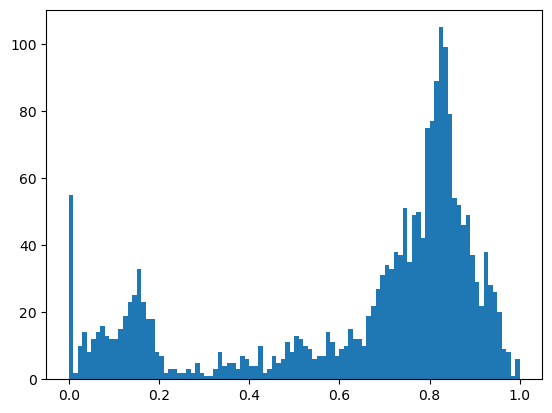

In [ ]:
def calculate_fraction_in_fticr(df,group_term='parquet'):
    df = df[pd.notna(df['predicted_formula'])]
    result_true = df[df['isin_fticr_formula'] == True].groupby(group_term)['predicted_formula'].nunique()
    result_false = df[df['isin_fticr_formula'] == False].groupby(group_term)['predicted_formula'].nunique()
    combined_result = pd.concat([result_true, result_false], axis=1)
    combined_result.columns = ['formula_count_in_fticr', 'formula_count_not_in_fticr']

    combined_result.fillna(0, inplace=True)
    combined_result['fraction_formula_in_fticr'] = combined_result['formula_count_in_fticr'] / (combined_result['formula_count_in_fticr'] + combined_result['formula_count_not_in_fticr'])
    combined_result.reset_index(inplace=True,drop=False)
    
    return combined_result

formula_df = pd.read_csv('/global/homes/b/bpb/repos/scndb/data/merged_fticr_formula (2).csv')
formula_df.drop(columns=['Unnamed: 0'], inplace=True)
# Add new columns for each unique value in "environment type"
# cols = ['formula','environment_type']
# formula_df = pd.pivot_table(formula_df[cols], index='formula', columns='environment_type', aggfunc=lambda x: True, fill_value=False)
cols =  ['environment_type', 'extraction_solvent',
       'ppl_extracted', 'instrument_type',
       'mass_range', 'doi']
for c in cols:
    env = formula_df.groupby(['formula',c])['polarity'].count().unstack().fillna(0)
    env[env>0] = 1
    env.columns = ['%s:%s'%(c,x) for x in env.columns]
    env = env.astype(int)
    formula_df = formula_df.merge(env, left_on='formula', right_index=True)
    formula_df.drop(columns=c, inplace=True)
    print(c)
formula_df.drop_duplicates(subset='formula', inplace=True)
formula_df.reset_index(drop=True, inplace=True)

formula_df.drop(columns=['mz','ionization_method','polarity'],inplace=True)
all_mdm_df['isin_fticr_formula'] = all_mdm_df['predicted_formula'].isin(formula_df['formula'])

fraction_in_fticr = calculate_fraction_in_fticr(all_mdm_df)

df = pd.merge(df,fraction_in_fticr,on='parquet',how='left')
v = all_mdm_df.groupby('parquet')['isin_fticr_formula'].mean().sort_values(ascending=True)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist(v,bins=100)


In [ ]:
print(all_mdm_df.shape,df.shape)
all_mdm_df = all_mdm_df[all_mdm_df['parquet'].isin(v[v>0.5].index.tolist())]
df = df[df['parquet'].isin(all_mdm_df['parquet'].unique())]
print(all_mdm_df.shape,df.shape)
cols = ['formula_count_in_fticr','formula_count_not_in_fticr']
files_no_formula = df.loc[df[cols].sum(axis=1)<10,'parquet'].tolist()
df = df[~df['parquet'].isin(files_no_formula)]
all_mdm_df = all_mdm_df[all_mdm_df['parquet'].isin(df['parquet'].unique())]
print(all_mdm_df.shape,df.shape)

(833718, 16) (2622, 54)
(773114, 16) (1575, 54)
(773084, 16) (1566, 54)


# Get hits to MDM and original spectra

In [ ]:
mz_tol = 0.002
deltas = pd.read_csv(os.path.join(metadata_folder,'mdm_neutral_losses.csv'))
ref,ref2 = wt.get_p2d2(deltas,mz_tol=mz_tol)
print(ref.shape)
ref.reset_index(inplace=True,drop=True)
ref2.reset_index(inplace=True,drop=True)
print(ref.shape)
ref_spec = ref['spectrum'].tolist()
ref_pmz = ref['precursor_mz'].tolist()

ref_spec_nl = ref2['nl_spectrum'].tolist()
ref_pmz_nl = ref2['precursor_mz'].tolist()

def score_df(df):
    min_matches=3,
    min_score=0.7,
    override_matches=20
    df.reset_index(inplace=True,drop=True)
    q_cols = ['predicted_formula','precursor_mz']
    r_cols = ['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']

    if df.shape[0]==0:
        return None
    if 'mdm_mz_vals' not in df.columns:
        return None
    df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x) if type(x)!=float else 0)

    df = df[df['num_mdm_frags']>0]


    df['mdm_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    df['original_spectrum'] = df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)

    query_spec = df['original_spectrum'].tolist()
    query_pmz = df['precursor_mz'].tolist()
    query_spec_nl = df['mdm_spectrum'].tolist()
    query_pmz_nl = df['precursor_mz'].tolist()

    d_specs = blink.discretize_spectra(query_spec,  ref_spec, query_pmz, ref_pmz, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    d_specs_nl = blink.discretize_spectra(query_spec_nl,  ref_spec_nl, query_pmz_nl, ref_pmz_nl, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    
    def score_and_filter(specs,r,q,mz_tol=0.002,min_score=0.7,min_matches=3,override_matches=20,
                         q_cols=['predicted_formula','precursor_mz'],
                         r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']):
        scores = blink.score_sparse_spectra(specs)
        filtered_scores = blink.filter_hits(scores,min_score=min_score,min_matches=min_matches,override_matches=override_matches,)
        mz_df = blink.reformat_score_matrix(filtered_scores)
        mz_df = blink.make_output_df(mz_df)
        for c in mz_df.columns:
            mz_df[c] = mz_df[c].sparse.to_dense()

        mz_df = pd.merge(mz_df,q[q_cols],left_on='query',right_index=True)
        mz_df = pd.merge(mz_df,r[r_cols].add_suffix('_ref'),left_on='ref',right_index=True)
        # mz_df = mz_df[mz_df['predicted_formula']==mz_df['formula']]
        mz_df = mz_df[abs(mz_df['precursor_mz']-mz_df['precursor_mz_ref'])<mz_tol]
        # mz_df.sort_values('score',ascending=False,inplace=True)
        # mz_df.drop_duplicates('inchi_key_ref',keep='first',inplace=True)
        return mz_df
    orig_hits = score_and_filter(d_specs,ref,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=q_cols,
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    nl_hits = score_and_filter(d_specs_nl,ref2,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=q_cols,
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index_ref'],how='outer',suffixes=('_original','_mdm'))
    if temp.shape[0]==0:
        return None
    temp['max_score'] = temp[['score_original','score_mdm']].max(axis=1)
    temp['best_match_method'] = temp[['score_original','score_mdm']].idxmax(axis=1)
    temp.sort_values('max_score',ascending=False,inplace=True)
    temp = temp[temp['max_score']>min_score]  #filter on score
    temp['max_matches'] = 0
    idx = temp['best_match_method']=='score_original'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
    idx = temp['best_match_method']=='score_mdm'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_mdm']
    temp = temp[temp['max_matches']>=min_matches]  #filter on matches


    cols = ['score_original','matches_original', 'score_mdm', 'matches_mdm']
    temp.drop(columns=cols,inplace=True)
    temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

    idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
    temp = temp[~idx_isolated] #filter on isolated precursor

    cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
    temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index_ref',right_on='original_p2d2_index',how='left')

    idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
    temp = temp[idx_precursor] #filter on precursor m/z
    
    # temp.sort_values('max_score',ascending=False,inplace=True)
    # temp = temp.groupby('query').head(1)
    # temp.reset_index(inplace=True,drop=True)
    return temp


# split all_mdm_df into chunks that are roughly 1000 large
chunks = np.array_split(all_mdm_df, np.ceil(len(all_mdm_df) / 1000))

def process_row(chunk):
    temp = score_df(chunk)
    return temp
    

with multiprocessing.Pool(10) as pool:
    out = pool.map(process_row, chunks)

out = pd.concat(out)
out.to_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))


(25677, 9)
(25677, 9)


KeyboardInterrupt: 

In [ ]:




def calculate_mass(formula):
    # Regular expression to match elements and their counts
    pattern = r'([A-Z][a-z]*)(\d*)'    
    mass = 0
    pt = rdchem.GetPeriodicTable()

    for el, count in re.findall(pattern, formula):
        # If count is an empty string, it means there's only one atom of this element
        count = int(count) if count else 1
        mass += pt.GetMostCommonIsotopeMass(el) * count
    return mass

unique_formulas = all_mdm_df['predicted_formula'].unique()
masses = {f:calculate_mass(f) for f in unique_formulas}
all_mdm_df['predicted_mass'] = all_mdm_df['predicted_formula'].map(masses)
all_mdm_df['predicted_mass'] = all_mdm_df['predicted_mass'] - 1.007276
all_mdm_df['mass_error'] = abs(all_mdm_df['precursor_mz'] - all_mdm_df['predicted_mass'])




# there better be nothing to remove here

In [ ]:
all_mdm_df.groupby('parquet')['mass_error'].median().sort_values(ascending=False).head(10)


parquet
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v03/MSV000087572/raw/mzML/NEG_MSMS_mzML/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep2.parquet             0.000785
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000087572/ccms_peak/raw data/NEG_MSMS_raw/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep2.parquet    0.000783
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000087572/ccms_peak/raw data/NEG_MSMS_raw/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep1.parquet    0.000771
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_peak/RAW/NEG MSMS/DOM_Interlab-LCMS_lab22_A5M_NEG_MSMS_rep1.parquet              0.000768
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v03/MSV000087572/raw/mzML/NEG_MSMS_mzML/DOM_Interlab-LC-MS_Lab20_A45M_Neg_MS2_rep1.parquet             0.000762
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v03/MSV000087572/raw/mzM

# Merge hdf5 filename with the parquet filenames in all_mdm_df

# copy any missing hdf5 files to where they are supposed to be

In [ ]:
cols=['filename','parquet']
files_df = all_mdm_df[cols].copy()
files_df.drop_duplicates(inplace=True)
files_df.reset_index(drop=True,inplace=True)
files_df['h5_missing'] = [not os.path.exists(f.replace('.parquet','.h5')) for f in files_df['parquet']]
files_to_copy = files_df[files_df['h5_missing']].copy()
files_to_copy['original_h5_missing'] = [not os.path.exists(f) for f in files_to_copy['filename']]
print(sum(files_to_copy['original_h5_missing']))
for i,row in files_to_copy.iterrows():
    parquet_file = row['parquet']
    h5_file = parquet_file.replace('.parquet','.h5')
    source_file = row['filename']
    dest_file = h5_file
    print('Copying %s to %s'%(source_file,dest_file))
    os.system('cp "%s" "%s"'%(source_file,dest_file))

all_mdm_df['h5'] = [f.replace('.parquet','.h5') for f in all_mdm_df['parquet']]


0


# Calculate the MS1 evidence for the predicted precursor in the MDM spectra

In [ ]:
# FILTER OUT ANY SPECTRA THAT DO NOT HAVE MS1 OR NOT CALIBRATED WELL


def calculate_ms1_summary(row):
    """
    Calculate summary properties for features from data
    """
    d = {}
    #Before doing this make sure "in_feature"==True has already occured
    d['num_datapoints'] = row['i'].count()
    if d['num_datapoints'] == 0:
        return pd.Series(d)
    d['peak_area'] = row['i'].sum()
    idx = row['i'].idxmax()
    d['peak_height'] = row.loc[idx,'i']
    d['mz_centroid'] = sum(row['i']*row['mz'])/d['peak_area']
    d['rt_peak'] = row.loc[idx,'rt']
    return pd.Series(d)

def make_atlas(df,ppm_tolerance = 5,mz_tol = 0.002,extra_rt=1):
    atlas = df.copy()
    atlas.rename(columns={'original_index':'label','rt':'rt_peak','precursor_mz':'mz'},inplace=True)
    atlas['rt_min'] = atlas['rt_peak'] - extra_rt
    atlas['rt_max'] = atlas['rt_peak'] + extra_rt
    atlas['mz_tolerance'] = mz_tol
    atlas['ppm_tolerance'] = ppm_tolerance
    atlas['extra_time'] = 0
    atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
                                        stepsize=ppm_tolerance,
                                        do_ppm=True)
    return atlas




def process_row(gg):
    filename = gg[0]
    atlas = make_atlas(gg[1])
    # try:
    d = ft.get_atlas_data_from_file(filename,atlas,desired_key='ms1_neg')
    # d = d[d['in_feature']==True]
    # except:
    #     print('Can not read',filename)
    d = d.groupby('label',group_keys=True).apply(calculate_ms1_summary)
    return d


cols = ['original_index','precursor_mz',  'rt']

g = [(_,gg[cols]) for _,gg in all_mdm_df[pd.notna(all_mdm_df['h5'])].groupby('h5')]    
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row,g)    
out = pd.concat(out)

cols = ['num_datapoints','peak_area','peak_height','mz_centroid','rt_peak']
out = out[cols]


# temp = pd.merge(out,all_df[cols],left_on='label',right_on='original_index',how='inner')
# temp['ppm_error'] = abs(temp['mz_centroid']-temp['precursor_mz']) / temp['precursor_mz'] * 1e6
# temp = temp[temp['ppm_error']<5]
# temp = temp[temp['num_datapoints']>5]
# # fig,ax = plt.subplots()
# # temp['num_datapoints'].apply(np.log10).hist(bins=100,ax=ax)


# all_df = all_df[all_df.index.isin(temp['label'])]

In [ ]:
out.reset_index(inplace=True,drop=False)
out.shape

(722616, 6)

In [ ]:
temp = pd.merge(out.add_suffix('_ms1'),all_mdm_df,left_on='label_ms1',right_on='original_index',how='right')
print(temp.shape[0])
temp = temp[temp['num_datapoints_ms1']>2]
temp = pd.merge(temp,df,left_on='parquet',right_on='parquet',how='left')
if 'hash_value' in temp.columns:
    temp.drop(columns=['hash_value'],inplace=True)
print(temp.shape[0])

773084
704082


In [ ]:
cols = ['formula_count_in_fticr','h5_x', 'h5_y','filename','redu_filename',
       'files_per_experiment', 'ms2_mz_vals',
       'ms2_i_vals','label_ms1','formula_count_in_fticr',
       'formula_count_not_in_fticr', 'fraction_formula_in_fticr']
cols = [c for c in cols if c in temp.columns]
temp.drop(columns=cols,inplace=True)
temp.to_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))

In [ ]:
mz_tol = 0.002
min_intensity_ratio = 2
similarity_cutoff = 0.5

# Export table of files used

In [ ]:
all_spectra = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))
cols = ['parquet', 
       'experiment_id', 'massive_id',
       'title_massive', 'dataset_massive', 'description_massive',
       'instrument_massive', 'keywords_massive', 'filename_redu',
       'attribute_datasetaccession_redu', 'sampletype_redu',
       'sampletypesub1_redu', 'ncbitaxonomy_redu', 'ncbidivision_redu',
       'ncbirank_redu', 'yearofanalysis_redu', 'uberonbodypartname_redu',
       'biologicalsex_redu', 'ageinyears_redu', 'lifestage_redu',
       'country_redu', 'healthstatus_redu', 'chromatographyandphase_redu',
       'ionizationsourceandpolarity_redu', 'massspectrometer_redu',
       'sampleextractionmethod_redu', 'samplecollectionmethod_redu',
       'comorbiditylistdoidindex_redu', 'doidcommonname_redu',
       'doidontologyindex_redu', 'envoenvironmentbiome_redu',
       'depthoraltitudemeters_redu', 'humanpopulationdensity_redu',
       'internalstandardsused_redu', 'latitudeandlongitude_redu',
       'samplecollectiondateandtime_redu', 'envoenvironmentmaterial_redu',
       'envoenvironmentbiomeindex_redu', 'envoenvironmentmaterialindex_redu',
       'subjectidentifierasrecorded_redu', 'termsofposition_redu',
       'uberonontologyindex_redu', 'uniquesubjectid_redu', 'usi_redu',
       'datasource_redu']
all_spectra = all_spectra[cols]
all_spectra.drop_duplicates(subset='parquet',inplace=True)
all_spectra.reset_index(drop=True,inplace=True)
all_spectra['h5'] = [f.replace('.parquet','.h5') for f in all_spectra['parquet']]

all_spectra.to_csv(os.path.join(metadata_folder,'all_files_for_environetwork.csv'),index=False)

In [ ]:
all_spectra = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))

all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))

all_hits.sort_values('max_score',ascending=False,inplace=True)
all_hits.drop_duplicates('original_index_query',keep='first',inplace=True)
all_spectra = pd.merge(all_spectra,all_hits[['inchi_key','max_score','original_index_query']].add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
all_spectra['max_score_identity'] = all_spectra['max_score_identity'].fillna(0)
all_spectra['inchi_key_identity'] = all_spectra['inchi_key_identity'].fillna('')
# chunk df into smaller dataframes using natural breaks in the precursor m/z greater than 0.01
all_spectra.sort_values('precursor_mz',inplace=True)
all_spectra['precursor_mz_group'] = ft.group_consecutive(all_spectra['precursor_mz'].values[:],stepsize=mz_tol,do_ppm=False)



In [ ]:
all_spectra['num_mdm_frags'] = all_spectra['mdm_mz_vals'].apply(lambda x: len(x))

<Axes: >

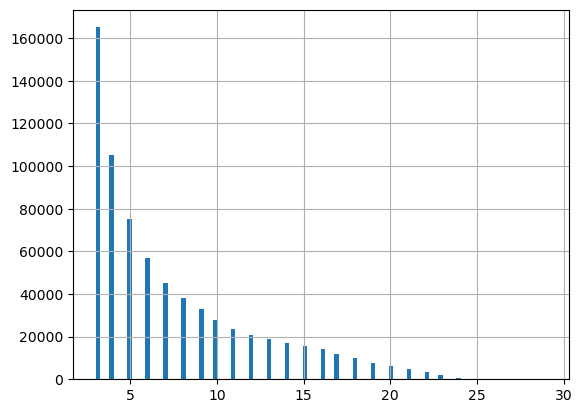

In [ ]:
all_spectra['num_mdm_frags'].hist(bins=100)

# A  better way might be to start with the unique compound nodes and then add to them until you don't find any more unique!

In [ ]:
def eliminate_duplicate_spectra(ms2_df):
    ms2_df['sum_frag_intensity'] = ms2_df['mdm_i_vals'].apply(lambda x: x.sum())
    ms2_df['max_score_identity'] = ms2_df['max_score_identity'].fillna(0)
    ms2_df.sort_values(['max_score_identity','sum_frag_intensity'],ascending=False,inplace=True) # 
    ms2_df.reset_index(inplace=True,drop=True)
    spec = ms2_df.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1).tolist()
    precursors = ms2_df['precursor_mz'].tolist()
    d_specs = blink.discretize_spectra(spec,  spec, precursors, precursors, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    scores = blink.score_sparse_spectra(d_specs)
    similarity_matrix = scores['mzi'].todense()
    
    iks = ms2_df['inchi_key_identity'].values
    idx_ik_same = iks[:,None] == iks
    # idx_ik_same = idx_ik_same.astype(int)

    has_ik = iks!=''
    idx_has_ik = has_ik[:,None] != has_ik

    # idx_ik_same = idx_ik_same | idx_no_ik
    idx_ik_same_or_dominant = idx_ik_same | idx_has_ik

    pmz_diff = abs(np.subtract.outer(ms2_df['precursor_mz'].values,ms2_df['precursor_mz'].values))
    idx = np.triu_indices(pmz_diff.shape[0],k=0)
    pmz_diff[idx] = 1000
    
    frag_intensity = ms2_df['sum_frag_intensity'].values
    intensity_diff = -1*np.subtract.outer(frag_intensity,frag_intensity)
    intensity_diff = intensity_diff / frag_intensity[:,None]
    idx_pmz_same = pmz_diff<mz_tol
    idx_intensity_greater = intensity_diff>min_intensity_ratio
    idx_ms2similarity = similarity_matrix>similarity_cutoff
    
    conditions = (idx_pmz_same) & ((idx_intensity_greater) | (idx_ms2similarity)) & (idx_ik_same_or_dominant)
    r,c = np.argwhere(conditions).T
    ms2_df = ms2_df[~ms2_df.index.isin(r)]
    return ms2_df

def process_row(gg):
    return eliminate_duplicate_spectra(gg[1])

cols = ['precursor_mz','predicted_formula','original_index','mdm_mz_vals','mdm_i_vals','inchi_key_identity','max_score_identity','precursor_mz_group']
g = [(_,gg[cols]) for _,gg in all_spectra.groupby('precursor_mz_group')]
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row,g)
out = pd.concat(out)
idx1 = all_spectra['original_index'].isin(out['original_index'])

# # make sure to get all the spectra that have identity matches to every unique inchi key
# all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquer'))
# all_hits.sort_values('max_score',ascending=False,inplace=True)
# all_hits.drop_duplicates('inchi_key',keep='first',inplace=True)
# idx2 = all_spectra['original_index'].isin(all_hits['original_index_query'])

node_data = all_spectra[idx1]
# node_data.drop_duplicates('original_index',inplace=True)
node_data.shape

(13012, 71)

# merge in the top hit for each spectrum

In [ ]:
all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))
all_hits.sort_values('max_score',ascending=False,inplace=True)
all_hits.drop_duplicates('original_index_query',keep='first',inplace=True)
node_data.drop(columns=['inchi_key_identity','max_score_identity','original_index_query_identity'],inplace=True)
node_data = pd.merge(node_data,all_hits.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')

In [ ]:
node_data.columns

Index(['num_datapoints_ms1', 'peak_area_ms1', 'peak_height_ms1',
       'mz_centroid_ms1', 'rt_peak_ms1', 'original_index', 'precursor_mz',
       'isolated_precursor_mz', 'rt', 'coisolated_precursor_count',
       'mdm_mz_vals', 'mdm_i_vals', 'original_mz_vals', 'original_i_vals',
       'predicted_formula', 'estimated_fdr', 'parquet', 'isin_fticr_formula',
       'predicted_mass', 'mass_error', 'experiment_id', 'massive_id',
       'title_massive', 'dataset_massive', 'description_massive',
       'instrument_massive', 'keywords_massive', 'filename_redu',
       'attribute_datasetaccession_redu', 'sampletype_redu',
       'sampletypesub1_redu', 'ncbitaxonomy_redu', 'ncbidivision_redu',
       'ncbirank_redu', 'yearofanalysis_redu', 'uberonbodypartname_redu',
       'biologicalsex_redu', 'ageinyears_redu', 'lifestage_redu',
       'country_redu', 'healthstatus_redu', 'chromatographyandphase_redu',
       'ionizationsourceandpolarity_redu', 'massspectrometer_redu',
       'sampleextract

In [ ]:
node_data['original_index_query_identity'].nunique(),node_data['inchi_key_identity'].nunique(),node_data.shape

(1767, 1624, (13012, 96))

In [ ]:


node_data.reset_index(inplace=True,drop=True)
node_data['mdm_spectrum'] = node_data.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1)
node_data['original_spectrum'] = node_data.apply(lambda row: np.array([row['original_mz_vals'],row['original_i_vals']]),axis=1)
# this is where you merge in any spectra that have a identity hit
# out.reset_index(inplace=True,drop=True)
# temp = pd.concat([df,out],axis=0)
# temp.reset_index(inplace=True,drop=True)
mass_diffs = [0] + deltas['mass'].tolist()
node_chunks = np.array_split(node_data, np.ceil(len(node_data) / 1000))
rem_df = []
for i,chunk in enumerate(node_chunks):
    temp_edges = wt.do_remblink_networking(chunk,node_data,mass_diffs=mass_diffs,spectra_attr='mdm_spectrum')
    temp_edges.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
    cols = ['ref','query','rem_blink_score']
    temp_edges = temp_edges[cols]
    temp_edges['query'] = temp_edges['query']+(i*chunk.shape[0])
    rem_df.append(temp_edges)
    

rem_df = pd.concat(rem_df)
print(rem_df.shape)


Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_negative_random_forest.joblib
Using /global/homes/b/bpb/repos/blink/models/mdm_neg

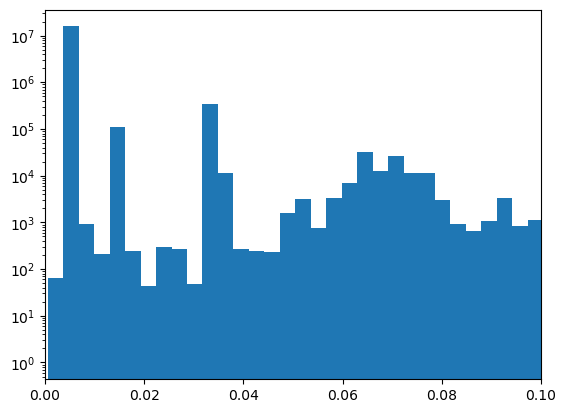

In [ ]:
fig,ax = plt.subplots()
ax.hist(rem_df['rem_blink_score'],bins=200)
ax.set_yscale('log')
ax.set_xlim(0,0.1)
plt.show()

In [ ]:

rem_df = rem_df[rem_df['rem_blink_score']>0.05]
print(rem_df.shape)

(196737, 3)


In [ ]:
# df.to_csv(os.path.join(metadata_folder,'calibrated_parquet_files_with_metadata.tsv'), sep='\t',index=False)

In [ ]:
p = wt.get_formula_props(node_data,formula_key='predicted_formula')
node_data = pd.merge(node_data,p,left_on='predicted_formula',right_on='formula',how='left')

In [ ]:
if 'original_index' in node_data.columns:
    node_data.drop(columns=['original_index'],inplace=True)
node_data.index.name = 'original_index'
node_data.reset_index(inplace=True,drop=False)


In [ ]:
import networkx as nx
# # Create the graph from the similarity matrix
G_draft = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_blink_score')
G_draft.remove_edges_from([(u, v) for u, v in G_draft.edges() if u == v])         
G_draft.remove_nodes_from(list(nx.isolates(G_draft)))

G = G_draft.copy()

drop_cols = """mdm_mz_vals
mdm_i_vals
original_mz_vals
original_i_vals
mdm_spectrum
original_spectrum"""
drop_cols = drop_cols.split('\n')
cols = list(set(node_data.columns) - set(drop_cols))
node_data_dict = node_data[cols].fillna('').to_dict(orient='index')

nx.set_node_attributes(G, node_data_dict)



In [ ]:
from pyteomics import mgf

def make_mgf(output_filename,df,G,spectra_type='nl_spectrum'):
    cols = ['FEATURE_ID','SCANS','ORIGNAL_ID','PEPMASS','PRECURSOR_MZ','RTINSECONDS','CHARGE','MSLEVEL']
    temp = df[df.index.isin(G.nodes)].copy()
    temp.reset_index(inplace=True,drop=True)
    temp['FEATURE_ID'] = temp['original_index']
    temp['SCANS'] = temp.index.tolist() # probably needs +1
    temp['ORIGNAL_ID'] = temp['original_index']
    temp['CHARGE'] = '1-'
    temp['MSLEVEL'] = 2
    temp['RTINSECONDS'] = temp['rt']*60
    temp['PRECURSOR_MZ'] = temp['precursor_mz']
    temp['PEPMASS'] = temp['precursor_mz']

    spectra = []
    for i,row in temp.iterrows():
        spectra.append({'params':row[cols].to_dict(),
                        'm/z array':row[spectra_type][0],'intensity array':row[spectra_type][1]})
    mgf.write(spectra,output_filename)
    


make_mgf('/global/cfs/cdirs/metatlas/projects/carbon_network/nl_spectra.mgf',node_data,G,spectra_type='mdm_spectrum')
make_mgf('/global/cfs/cdirs/metatlas/projects/carbon_network/original_spectra.mgf',node_data,G,spectra_type='original_spectrum')


In [ ]:
from rdkit.Chem import MolFromSmiles, MolToInchiKey
smiles_col = 'smiles_identity'
# Get identity hits smiles for all nodes
identity_smiles = nx.get_node_attributes(G, smiles_col)
node_id = [k for k, v in identity_smiles.items() if isinstance(v,str)]
identity_smiles = [v for k, v in identity_smiles.items() if isinstance(v,str)]
df = pd.DataFrame(data=identity_smiles,columns=['smiles'])
df['node_id'] = node_id
df['mol'] = df['smiles'].apply(lambda x: MolFromSmiles(x) if x is not '' else None)
df['inchi_key'] = df['mol'].apply(lambda x: MolToInchiKey(x) if x is not None else None)

df

,smiles,node_id,mol,inchi_key
0,,6.0,None,None
1,,0.0,None,None
2,O=C(O)/C=C(/CC(=O)O)C(=O)O,577.0,<rdkit.Chem.rdchem.Mol object at 0x7f50eb2c2820>,GTZCVFVGUGFEME-IWQZZHSRSA-N
3,,1986.0,None,None
4,CC(=O)C(=O)O,1.0,<rdkit.Chem.rdchem.Mol object at 0x7f50eb4ba040>,LCTONWCANYUPML-UHFFFAOYSA-N
...,...,...,...,...
11027,,12962.0,None,None
11028,,12979.0,None,None
11029,,12969.0,None,None
11030,,12975.0,None,None


In [ ]:
import requests
import json

url = "https://npclassifier.gnps2.org/classify"
df.reset_index(inplace=True,drop=True)
out = []
for i,row in df[pd.notna(df['inchi_key'])].iterrows(): # for some reason smiles is "" and not None
    # smiles = df.loc[0,'smiles_identity']
    r = requests.get(url, params={"smiles": row['smiles']})
    if r.status_code == 200:
        d = r.json()
    else:
        if 'C' in row['smiles']:
            print(row['smiles'])
        d = {'class_results': None,
                     'superclass_results': None,
                     'pathway_results': None,
                     'isglycoside': False}
    d['inchi_key'] = row['inchi_key']
    out.append(d)

In [ ]:
out2 = pd.DataFrame(out)
cols = ['class_results', 'superclass_results', 'pathway_results']
for c in cols:
    out2[c] = out2[c].apply(lambda x: ','.join(sorted(x)) if isinstance(x,list) else '')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,GTZCVFVGUGFEME-IWQZZHSRSA-N
1,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,False,LCTONWCANYUPML-UHFFFAOYSA-N
2,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,JVTAAEKCZFNVCJ-UHFFFAOYSA-N
3,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,NPOAOTPXWNWTSH-UHFFFAOYSA-N
4,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,UDDSEESQRGPVIL-UHFFFAOYSA-N
...,...,...,...,...,...
1653,"Oleanane triterpenoids,Ursane and Taraxastane triterpenoids",Triterpenoids,Terpenoids,False,XINANDRKNJRDBH-KSJJSBHMSA-N
1654,"Flavan-3-ols,Flavanones",Flavonoids,Shikimates and Phenylpropanoids,False,PAUVEHXCLNBAPG-UHFFFAOYSA-N
1655,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,YHJDRJVMBSUEDI-UHFFFAOYSA-N
1656,Flavones,Flavonoids,Shikimates and Phenylpropanoids,False,HDUZOHKOFFWLBU-UHFFFAOYSA-N


In [ ]:
def replace_list_identifiers(df,identifier='class_results'):
    temp = df.loc[pd.notna(df[identifier]),identifier].tolist()
    temp = [x.split(',') for x in temp]
    temp = [item for sublist in temp for item in sublist]
    temp = pd.Series(temp)
    pathway_counts = temp.value_counts()
    for i,row in df[pd.notna(df[identifier])].iterrows():
        split_results = row[identifier].split(',')
        if len(split_results) > 1:
            d = {}
            for r in split_results:
                d[r] = pathway_counts[r]
            df.at[i, identifier] = max(d, key=d.get)

    return df

out2 = replace_list_identifiers(out2,identifier='class_results')
out2 = replace_list_identifiers(out2,identifier='pathway_results')
out2 = replace_list_identifiers(out2,identifier='superclass_results')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,GTZCVFVGUGFEME-IWQZZHSRSA-N
1,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,False,LCTONWCANYUPML-UHFFFAOYSA-N
2,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,JVTAAEKCZFNVCJ-UHFFFAOYSA-N
3,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,NPOAOTPXWNWTSH-UHFFFAOYSA-N
4,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,UDDSEESQRGPVIL-UHFFFAOYSA-N
...,...,...,...,...,...
1653,Oleanane triterpenoids,Triterpenoids,Terpenoids,False,XINANDRKNJRDBH-KSJJSBHMSA-N
1654,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,PAUVEHXCLNBAPG-UHFFFAOYSA-N
1655,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,YHJDRJVMBSUEDI-UHFFFAOYSA-N
1656,Flavones,Flavonoids,Shikimates and Phenylpropanoids,False,HDUZOHKOFFWLBU-UHFFFAOYSA-N


In [ ]:
df = pd.merge(df,out2,on='inchi_key',how='left')
df.reset_index(inplace=True,drop=True)
df

,smiles,node_id,mol,inchi_key,class_results,superclass_results,pathway_results,isglycoside
0,,6.0,None,None,NaN,NaN,NaN,NaN
1,,0.0,None,None,NaN,NaN,NaN,NaN
2,O=C(O)/C=C(/CC(=O)O)C(=O)O,577.0,<rdkit.Chem.rdchem.Mol object at 0x7f50eb2c2820>,GTZCVFVGUGFEME-IWQZZHSRSA-N,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False
3,,1986.0,None,None,NaN,NaN,NaN,NaN
4,CC(=O)C(=O)O,1.0,<rdkit.Chem.rdchem.Mol object at 0x7f50eb4ba040>,LCTONWCANYUPML-UHFFFAOYSA-N,Oxo fatty acids,Fatty Acids and Conjugates,Fatty acids,False
...,...,...,...,...,...,...,...,...
11313,,12962.0,None,None,NaN,NaN,NaN,NaN
11314,,12979.0,None,None,NaN,NaN,NaN,NaN
11315,,12969.0,None,None,NaN,NaN,NaN,NaN
11316,,12975.0,None,None,NaN,NaN,NaN,NaN


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
for c in ['class_results', 'superclass_results', 'pathway_results']:
    nx.set_node_attributes(G, df.set_index('node_id')[c].fillna('').to_dict(), c)


In [ ]:
nx.write_graphml(G,'/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_noprop.graphml')
G_filt = nx.maximum_spanning_tree(G)
nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst_noprop.graphml')

In [ ]:
G = nx.read_graphml('/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_noprop.graphml')
# main_column = 'pathway_results'
main_column = 'class_results'
all_columns = ['class_results', 'superclass_results', 'pathway_results']
df = G.nodes(data=True) 
df = pd.DataFrame(df, columns=['node_id', 'data'])
df.set_index('node_id', inplace=True)
df = df['data'].apply(pd.Series)
df.reset_index(inplace=True,drop=False)
df.head()

,node_id,isolated_precursor_mz,s,rt_peak_ms1,precursor_mz,p_to_c,num_datapoints_ms1,dbe_ai_mod,h,formula,peak_area_ms1,isin_fticr_formula,parquet,environmental,precursor_mz_group,o,mass_error,n,original_index,mz_centroid_ms1,predicted_mass,experiment_id,peak_height_ms1,o_to_c,nosc,ai,coisolated_precursor_count,estimated_fdr,dbe_ai,dbe,c,rt,predicted_formula,n_to_c,ai_mod,p,h_to_c,num_mdm_frags,plant,predicted_formula_original_identity,name_ref_original_identity,dataset_massive,precursor_mz_ref_original_identity,original_index_query_identity,instrument_massive,smiles_identity,coisolated_precursor_count_query_identity,keywords_massive,description_massive,precursor_mz_original_identity,max_matches_identity,formula_identity,massive_id,precursor_mz_query_identity,title_massive,inchi_key_ref_original_identity,precursor_mz_identity,name_identity,best_match_method_identity,ref_original_identity,max_score_identity,original_p2d2_index_identity,query_identity,formula_ref_original_identity,inchi_key_identity,original_p2d2_index_ref_identity,class_results,superclass_results,pathway_results,formula_ref_mdm_identity,predicted_formula_mdm_identity,precursor_mz_mdm_identity,ref_mdm_identity,precursor_mz_ref_mdm_identity,name_ref_mdm_identity,inchi_key_ref_mdm_identity,n_to_p
0,6.0,99.008789,0.0,0.379400,99.044913,0.0,312.0,1.0,8.0,C5H8O2,2.047800e+07,False,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_QE-HF_C18_USDAY63680_NEG_MSMS_15_P12-Control_5_Rg80to1200-CE102040-soil-Ultisol-S1_Run215.parquet,True,6,2.0,0.000241,0.0,6,99.045067,99.045153,SoilWetDry_final,3.402680e+05,0.400000,-0.800000,0.0,1,0.000000e+00,0.0,2.0,5.0,1.378,C5H8O2,0.0,0.250000,0.0,1.600000,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,85.029434,0.0,2.427047,85.029265,0.0,308.0,1.0,6.0,C4H6O2,3.197372e+07,False,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_QE-HF_C18_USDAY63680_NEG_MSMS_37_SC-Exclusion_2_Rg80to1200-CE102040-soil-Oxisol-S1_Run67.parquet,True,0,2.0,0.000238,0.0,0,85.029459,85.029503,SoilWetDry_final,1.394567e+06,0.500000,-0.500000,0.0,1,0.000000e+00,0.0,2.0,4.0,2.413,C4H6O2,0.0,0.333333,0.0,1.500000,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,577.0,173.045609,0.0,10.760242,173.009144,0.0,6.0,1.0,6.0,C6H6O6,1.761205e+05,True,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v04/MSV000088823/updates/2022-02-16_bciap01_2e2457db/peak/Peaks/mzmL/MS2_Neg_mode/DOM_Interlab-LCMS_Lab19_M_Neg_MS2_rep3.parquet,True,328,6.0,0.000017,0.0,577,173.009276,173.009162,MSV000088823,4.081973e+04,1.000000,1.000000,NaN,1,6.332788e-08,-2.0,4.0,6.0,11.437,C6H6O6,0.0,0.333333,0.0,1.000000,7,False,C6H6O6,cis-Aconitic acid,MSV000088823,173.0092,56389.0,MS:1001911;MS:1002523;MS:1001910;MS:1003112;MS:1003094,O=C(O)/C=C(/CC(=O)O)C(=O)O,1.0,Dissolved Organic Matter###interlab comparison,"Interlab Study of LC-MS/MS analyis of Marine Dissolved Organic Matter from SIO Pietr (San Diego, California, USA) and algae extracts, extracted via PPL SPE",173.009144,4.0,C6H6O6,MSV000088823,173.009144,GNPS DOM LC-MS/MS Interlab Comparison 2020 COMPILED Dataset,GTZCVFVGUGFEME-IWQZZHSRSA-N,173.0092,cis-Aconitic acid,score_original,1691.0,0.899847,102712.0,804.0,C6H6O6,GTZCVFVGUGFEME-IWQZZHSRSA-N,102712.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986.0,229.086899,0.0,4.710310,229.034573,0.0,6.0,1.5,10.0,C9H10O7,3.983366e+06,True,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v05/MSV000090678/peak/mzML_Negative/HBH0622_34a_NEG.parquet,True,1080,7.0,0.000803,0.0,1986,229.033892,229.035377,MSV000090678,1.229032e+06,0.777778,0.444444,-1.0,5,0.000000e+00,-2

In [ ]:

# def get_most_common(classes):
#     class_counts = Counter(classes)
#     # Get the most common string
#     most_common_class = class_counts.most_common(1)[0][0]
#     return most_common_class

# classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
# superclass_name = []
# class_name = []
# subclass_name = []
# iks = df.loc[pd.notna(df['inchi_key']),'inchi_key'].unique()
# for ik in iks:
#     f = '%s.json'%ik
#     f = os.path.join(classyfire_dir,f)
#     with open(f,'r') as fid:
#         cf = fid.read()
#     cf = json.loads(cf.strip())
#     if isinstance(cf,str):
#         cf = json.loads(cf)
#     # cf_json = json.dumps(cf)
#     if not main_column in cf:
#         cf[main_column] = {'name':None}
#     if not 'superclass' in cf:
#         cf['superclass'] = {'name':None}
#         cf['class'] = {'name':None}
#     if cf[main_column] is None:
#         cf[main_column] = {'name':None}
#     superclass_name.append(cf['superclass']['name'])
#     class_name.append(cf['class']['name'])
#     subclass_name.append(cf[main_column]['name'])

# temp = pd.DataFrame(index=iks)
# temp['superclass'] = superclass_name
# temp['class'] = class_name
# temp[main_column] = subclass_name

# df = pd.merge(df,temp,left_on='inchi_key',right_index=True,how='left')

# df

In [ ]:
df.loc[df['node_id']=='41.0',all_columns]

,class_results,superclass_results,pathway_results
34,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids


In [ ]:

def min_additional_subgraph(graph, original_nodes,radius=1,min_count=0):
    nodes = []
    for node in original_nodes:
        # Create an ego graph centered at the current node
        
        ego_subgraph = nx.ego_graph(graph, node,radius=radius)
        nodes.extend(list(ego_subgraph.nodes))
    df = pd.DataFrame(data=nodes,columns=['nodes'])
    df = df.groupby('nodes').filter(lambda x: len(x) >= min_count)
    nodes = df['nodes'].tolist() + original_nodes
    
    nodes = list(set(nodes))
    nodes = sorted(nodes)
    return nodes

sc_df = pd.DataFrame()
sc_df['node_id'] = df['node_id'].values
sc_df[main_column] = df[main_column].values
for class_name in sc_df.loc[pd.notna(sc_df[main_column]),main_column].unique():
    idx = sc_df[main_column]==class_name
    original_nodes = sc_df.loc[idx,'node_id'].tolist()
    new_nodes = min_additional_subgraph(G, original_nodes,radius=2,min_count=3)
    sc_df[class_name] = False
    # idx = sc_df['node_id'].isin(original_nodes)
    # sc_df.loc[idx,class_name] = True
    idx = sc_df['node_id'].isin(new_nodes)
    sc_df.loc[idx,class_name] = True
sc_df.set_index('node_id',inplace=True)
sc_df.drop(columns=[main_column],inplace=True)
sc_df
# For each row in the DataFrame
# If the sum of the row is greater than 1
# Find the class with the highest frequency
# Set all other classes to False

,Dicarboxylic acids,Oxo fatty acids,Hydroxy fatty acids,4-pyrone derivatives,Simple phenolic acids,Acyl phloroglucinols,Miscellaneous polyketides,Monosaccharides,Unsaturated fatty acids,Branched fatty acids,Dipeptides,Shikimic acids and derivatives,Cinnamic acids and derivatives,Simple coumarins,Isocoumarins,Aminoacids,Wax monoesters,Menthane monoterpenoids,Acyclic monoterpenoids,Macrolide lactones,Simple indole alkaloids,Quinoline alkaloids,Chromones,Phenylethylamines,Arylnaphthalene and aryltetralin lignans,Naphthalenes and derivatives,pteridine alkaloids,Rotenoids,Pinane monoterpenoids,Pyridine alkaloids,Irregular monoterpenoids,Acetogenins,Pyrrolidine alkaloids,Phenanthrenes,Kaurane and Phyllocladane diterpenoids,2-pyrone derivatives,p-Terphenyls,Phthalide derivatives,Plant xanthones,Cyclitols,Naphthoquinones,Catechols with side chains,Meromonoterpenoids,Anthraquinones and anthrones,Open-chain polyketides,Iridoids monoterpenoids,Oligomeric phloroglucinols (phlorotannins),Sorbicilinoids,Naphthalenones,Jasmonic acids,Simple cyclic polyketides,Phenylethanoids,Germacrane sesquiterpenoids,Monomeric stilbenes,Phenazine alkaloids,Methyl xanthones,Picrotoxane sesquiterpenoids,Acridone alkaloids,Azaphilones,Eremophilane sesquiterpenoids,Apocarotenoids(ε-),Flavones,Isoflavones,Camphane monoterpenoids,Chalcones,Caryophyllane sesquiterpenoids,Flavonols,Flavanones,Pulvinones,Fungal DPEs,Heterocyclic fatty acids,Eudesmane sesquiterpenoids,Pentalenane sesquiterpenoids,Humulane sesquiterpenoids,Isoflavanones,Zearalenones,Prenyl quinone meroterpenoids,Quadrane sesquiterpenoids,Paraconic acids and derivatives,Gallotannins,Guaiane sesquiterpenoids,Isoindole alkaloids,Pseudoguaiane sesquiterpenoids,Acorane sesquiterpenoids,Bisabolane sesquiterpenoids,Daucane sesquiterpenoids,Iphionane sesquiterpenoids,Cadinane sesquiterpenoids,Prostaglandins,Podocarpane diterpenoids,Neoflavonoids,Dihydroflavonols,Aurones,Pyranocoumarins,Cannabinoids,Estrane steroids,Prezizaane sesquiterpenoids,Gibberellins,Furans,Secogermacrane sesquiterpenoids,Carabrane sesquiterpenoids,12-oxophytodienoic acid metabolites,Neolignans,Pterocarpan,Flavan-3-ols,Benzoquinones,Dibenzylbutyrolactone lignans,Fatty alcohols,Depsidones,Linear diarylheptanoids,N-acyl amines,Dibenzylbutane lignans,Colensane and Clerodane diterpenoids,Valerenane sesquiterpenoids,Other Octadecanoids,Labdane diterpenoids,Apocarotenoids (β-),Halimane diterpenoids,Other Eicosanoids,Hydroxy-hydroperoxyeicosapentaenoic acids,Hydroxy-hydroperoxyeicosatetraenoic acids,Ursane and Taraxastane triterpenoids,Furocoumarins,Epoxy fatty acids,3-Spirotetramic acids,Coumestan,Brasilane sesquiterpenoids,Angucyclines,Abeoabietane diterpenoids,Cembrane diterpenoids,Furanoid lignans,Pimarane and Isopimarane diterpenoids,Icetexane diterpenoids,Abietane diterpenoids,Indole diketopiperazine alkaloids (L-Trp,Norlabdane diterpenoids,Tetracyclic diterpenoids,Lipoxins,Epoxyeicosatrienoic acids,Phytane diterpenoids,Phytoprostanes,Hydroxy-hydroperoxyeicosatrienoic acids,Arteminisin,Nitro fatty acids,Quinazoline alkaloids,Pregnane steroids,Leukotrienes,Isoprostanes,Biaryl type diarylheptanoids,Merosesquiterpenoids,Phytofurans,Other Docosanoids,Maresins,Serrulatane and Biflorane diterpenoids,Polyprenylated cyclic polyketides (Hop meroterpenoids),Miscellaneous apocarotenoids,Thromboxanes,Grayanotoxane diterpenoids,Carboline alkaloids,Androstane steroids,Usnic acid and derivatives,Depsides,Resolvin Ds,Diarylether type diarylheptanoids,Cardenolides,Pachydictyane diterpenoids,Cholane steroids,Tetraketide meroterpenoids,Furofuranoid lignans,Cholestane steroids,Limonoids,Coumaronochromones,3-Decalinoyltetramic acids,Oligomeric stibenes,Oleanane triterpenoids,Abeolupane triterpenoids,Ansa macrolides,Farnesane sesquiterpenoids,Lanostane,Lupane triterpenoids,Fusidane triterpenoids
node_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [ ]:
# for columns with more than one True value, get the regional value_counts from an ego graph of radius 5 and replace with the most common value
for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
    ego_subgraph = nx.ego_graph(G, i,radius=3) #was 5
    nodes = list(ego_subgraph.nodes)
    temp = sc_df.loc[nodes]
    temp = temp.sum()
    temp = temp[temp>0]
    if len(temp)>0:
        most_common_class = temp.idxmax()
        sc_df.loc[i] = False
        sc_df.loc[i,most_common_class] = True



In [ ]:
# # make a list of the classes that are most common
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)
# # for nodes that are in more than one class, only keep the most abundant class
# for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
#     # get the most commonly occuring class
#     keep_class = ranked_frequency[row[row==True].index].sort_values(ascending=False).index[0]
#     # get the indices of all the assigned classes
#     idx = row[row==True].index
#     # drop all but the most common
#     idx = idx[idx!=keep_class]
#     # zero them out
#     sc_df.loc[i,idx] = False

In [ ]:
# for any class that has an ID in the original, reset it back to its original state
for i,row in df.iterrows():
    if pd.notna(row[main_column]):
        sc_df.loc[row['node_id'],:] = False
        sc_df.loc[row['node_id'],row[main_column]] = True


# recomute the ranked frequency now that ambiguous classes have been resolved
ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)

In [ ]:
cols = sc_df.columns
sc_df = sc_df.reset_index().melt(id_vars='node_id',value_vars=cols)
idx = sc_df['value']==True
sc_df = sc_df[idx]
sc_df = sc_df[pd.notna(sc_df['variable'])]
sc_df


,node_id,variable,value
0,6.0,Dicarboxylic acids,True
1,0.0,Dicarboxylic acids,True
2,577.0,Dicarboxylic acids,True
14,339.0,Dicarboxylic acids,True
15,582.0,Dicarboxylic acids,True
...,...,...,...
1974020,11700.0,Lanostane,True
1984393,10687.0,Lupane triterpenoids,True
1984436,11699.0,Lupane triterpenoids,True
1984443,10744.0,Lupane triterpenoids,True


In [ ]:
sc_df.value_counts('variable').head(40)

variable
Simple coumarins                             4309
Prostaglandins                               1323
Simple phenolic acids                         583
Aminoacids                                    246
Dicarboxylic acids                            113
Cholane steroids                              112
Chalcones                                      84
Cinnamic acids and derivatives                 78
Hydroxy fatty acids                            67
Tetraketide meroterpenoids                     60
Isoflavones                                    60
Flavones                                       57
Other Octadecanoids                            43
Oleanane triterpenoids                         42
Anthraquinones and anthrones                   36
Gibberellins                                   31
Flavonols                                      31
Ursane and Taraxastane triterpenoids           25
Dipeptides                                     24
Arteminisin                              

In [ ]:
sc_df

,node_id,variable,value
0,6.0,Dicarboxylic acids,True
1,0.0,Dicarboxylic acids,True
2,577.0,Dicarboxylic acids,True
14,339.0,Dicarboxylic acids,True
15,582.0,Dicarboxylic acids,True
...,...,...,...
1974020,11700.0,Lanostane,True
1984393,10687.0,Lupane triterpenoids,True
1984436,11699.0,Lupane triterpenoids,True
1984443,10744.0,Lupane triterpenoids,True


In [ ]:
# Add cluster labels to graph
cluster_dict = sc_df.copy()
cluster_dict.rename(columns={'variable':'structural_cluster_subclassname'},inplace=True)
print(cluster_dict.shape)
if main_column != 'pathway_results':
    cluster_dict = pd.merge(df[all_columns].drop_duplicates(main_column),cluster_dict,left_on=main_column,right_on='structural_cluster_subclassname',how='right')
else:
    cluster_dict[main_column] = cluster_dict['structural_cluster_subclassname']

cluster_dict.drop(columns=['structural_cluster_subclassname','value'],inplace=True)
cluster_dict.drop_duplicates('node_id',inplace=True)
cluster_dict.set_index('node_id',inplace=True)
cluster_dict.fillna('',inplace=True)
cluster_dict = cluster_dict.add_suffix('_propagated')

cluster_dict

(8044, 3)


,class_results_propagated,superclass_results_propagated,pathway_results_propagated
node_id,,,
6.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
0.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
577.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
339.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
582.0,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids
...,...,...,...
11700.0,Lanostane,Triterpenoids,Terpenoids
10687.0,Lupane triterpenoids,Triterpenoids,Terpenoids
11699.0,Lupane triterpenoids,Triterpenoids,Terpenoids


In [ ]:
print(cluster_dict.shape)
# need to understand why there are duplicates

cluster_dict = cluster_dict.to_dict(orient='index')

nx.set_node_attributes(G, cluster_dict)
# cluster_dict
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# len(clusters),len(set(clusters))

(8044, 3)


In [ ]:
df = G.nodes(data=True)
df = pd.DataFrame(df)
df.columns = ['node','data']
df['data'] = df['data'].apply(lambda x: dict(x))
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
df.reset_index(inplace=True,drop=True)
df.value_counts('pathway_results')

pathway_results
Shikimates and Phenylpropanoids    605
Fatty acids                        366
Terpenoids                         297
Polyketides                        150
Amino acids and Peptides           104
Alkaloids                           67
Carbohydrates                       12
dtype: int64

In [ ]:
df.value_counts('pathway_results_propagated')

pathway_results_propagated
Shikimates and Phenylpropanoids    5340
Fatty acids                        1679
Terpenoids                          510
Amino acids and Peptides            271
Polyketides                         173
Alkaloids                            58
Carbohydrates                        13
dtype: int64

In [ ]:
# df = G.nodes(data=True)
# df = pd.DataFrame(df)
# df.columns = ['node','data']
# df['data'] = df['data'].apply(lambda x: dict(x))
# df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
# df.reset_index(inplace=True,drop=True)
# df['consensus_class'] = None

# # Count the number of occurrences of each subclass
# subclass_counts = df[main_column].value_counts()

# # Get the subclasses that have at least 100 values
# large_subclasses = subclass_counts[subclass_counts >= 100].index

# # Set the consensus_class for large subclasses
# df.loc[df[main_column].isin(large_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(large_subclasses), main_column]

# # Get the subclasses that have less than 100 values
# small_subclasses = subclass_counts[subclass_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df[main_column].isin(small_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(small_subclasses), 'class']

# # Get the subclasses that have less than 100 values
# class_counts = df['consensus_class'].value_counts()
# small_classes = class_counts[class_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df['consensus_class'].isin(small_classes), 'consensus_class'] = df.loc[df['consensus_class'].isin(small_classes), 'superclass']

# df = df[['node','consensus_class']]

# df.loc[df['consensus_class'].map(df['consensus_class'].value_counts()) < 100, 'consensus_class'] = None

# df.fillna('',inplace=True)
# df.value_counts('consensus_class')
# nx.set_node_attributes(G, df.set_index('node')['consensus_class'].to_dict(), 'consensus_class')


In [ ]:
# import os
# import networkx as nx
# from pathlib import Path
# try:
#     module_path = os.path.join(Path(__file__).parents[2])
# except: # Jupyter notebook probably
#     module_path = os.path.join(os.getcwd(), '../../')
# graphml_file = os.path.join(module_path, 'data/CarbonNetwork.graphml')
# G = nx.read_graphml(graphml_file)


In [ ]:
nx.write_graphml(G,'/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork.graphml')
G_filt = nx.maximum_spanning_tree(G)
nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst.graphml')

In [ ]:
# Create a maximum spanning tree from G
T = nx.maximum_spanning_tree(G, weight='rem_blink_score')

# Get the list of edges in G sorted by weight in descending order
edges_sorted_by_weight = sorted(G.edges(data=True), key=lambda x: x[2]['rem_blink_score'], reverse=True)

# Add edges back to the tree from the original network until there are 30000 edges total in the network
for u, v, data in edges_sorted_by_weight:
    if T.number_of_edges() >= 20000:
        break
    if not T.has_edge(u, v):
        T.add_edge(u, v, **data)

print('nodes', len(T.nodes))
print('edges', len(T.edges))

# G.remove_nodes_from(list(nx.isolates(G)))
# k = 5  # replace with your desired k

# from blink.utils import filter_top_k
# # filter_top_k(G, top_k=k, edge_score='rem_blink_score')



# drop_cols = """mdm_mz_vals
# mdm_i_vals
# original_mz_vals
# original_i_vals
# mdm_spectrum
# original_spectrum"""
# drop_cols = drop_cols.split('\n')
# cols = list(set(node_data.columns) - set(drop_cols))

# node_data_dict = node_data[cols].fillna('').to_dict(orient='index')

# nx.set_node_attributes(T, node_data_dict)
# # Remove self-loops
# Remove isolates
T.remove_nodes_from(list(nx.isolates(T)))
print('nodes',len(T.nodes))
print('edges',len(T.edges))
nx.write_graphml(T,'network.graphml')
# nx.write_graphml(G,'CarbonNetwork.graphml')


nodes 11032
edges 20000
nodes 11032
edges 20000


In [ ]:

this will stop the run
# import networkx as nx

# # Get the connected components in the graph
components = list(nx.connected_components(G))

# # Filter out subgraphs with less than 1000 nodes
filtered_components = [component for component in components if len(component) >= 1000]

# # Create a new graph
G_filtered = nx.Graph()

# # Add each subgraph to the new graph
for component in filtered_components:
    G_filtered = nx.compose(G_filtered, G.subgraph(component))
    
# alg = 'sfdp'

# do it like this
# pos = graphviz_layout(G, prog='dot', root=0, args='-Grankdir="LR"')

alg = 'neato'
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="scale"')
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="False"') #blob
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="vpsc"') #crashes
pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="orthoxy"') #looks like a lightning bolt
pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="ipsep"') #looks like 
ipsep

for node, (x, y) in pos.items():
    G_filtered.nodes[node]['x'] = x
    G_filtered.nodes[node]['y'] = y

nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions.graphml'))


In [ ]:
import matplotlib.pyplot as plt
nx.draw(G_filtered, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=3)

plt.show()

In [ ]:
# remove node overlaps
pos = nx.kamada_kawai_layout(G_filtered)
for node, (x, y) in pos.items():
    G_filtered.nodes[node]['x'] = x
    G_filtered.nodes[node]['y'] = y
nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions_kamada-kawai.graphml'))